In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split
import copy


In [12]:
def standard_scalar_normalize(data_train, data_test): 
    scaler = StandardScaler()
    scaler.fit(data_train)
    normal_data_train = scaler.transform(data_train)
    normal_data_test = scaler.transform(data_test)
    return normal_data_train,normal_data_test

In [13]:
def data_processed():
    '''
    Used to read & normalize processed test and train data
    '''
    data_train=pd.read_csv("data/2022-02-07_LOANS_TRAIN.csv")
    data_test=pd.read_csv("data/2022-02-07_LOANS_TEST.csv")
    y_train=data_train['loan_status']
    data_train.drop(columns=['loan_status', 'id', 'issue_d_in_months', 'issue_d_year', 'zip_state_match', 
                               'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
                               'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                               'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                               'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
                               'WI', 'WV', 'WY'], inplace=True)
    
    data_test.drop(columns=['id', 'issue_d_in_months', 'issue_d_year', 'zip_state_match', 
                           'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
                           'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                           'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                           'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
                           'WI', 'WV', 'WY'], inplace=True)
    
    normal_data_train,normal_data_test=standard_scalar_normalize(data_train,data_test)
    return normal_data_train,normal_data_test,y_train

def AUC_score(y_ground_truth,y_predicted_probability):
    return roc_auc_score(y_ground_truth, y_predicted_probability)

def to_submission(ids, y_test_predicted_probability):
    y_test=pd.DataFrame(y_test_predicted_probability,columns=['loan_status'], index=ids)
    y_test.index.name = 'id'
    y_test.to_csv('data/submission.csv')
    return

In [14]:
def eval_tree_based_model_n_estimators(clf, n_estimators, X_train, y_train, X_test, y_test):
    """
    This function evaluates the given classifier (either a decision tree or random forest) at all of the 
    maximum tree depth parameters in the vector max_depth, using the given training and testing
    data. It returns two vector, with the training and testing classification errors.
    
    Inputs:
        clf: either a decision tree or random forest classifier object
        max_depth: a (T, ) vector of all the max_depth stopping condition parameters 
                            to test, where T is the number of parameters to test
        X_train: (N, D) matrix of training samples.
        y_train: (N, ) vector of training labels.
        X_test: (N, D) matrix of test samples
        y_test: (N, ) vector of test labels
    Output:
        train_err: (T, ) vector of classification errors on the training data
        test_err: (T, ) vector of classification errors on the test data
        train_auc: (T, ) vector of area under the ROC curve (AUC) on the training data
        test_auc: (T, ) vector of area under the ROC curve (AUC) on the testing data
    """
    train_err = []
    test_err = []
    train_auc = []
    test_auc = []
    for n_estimator in n_estimators: 
        print(n_estimator)
        clf.n_estimators = n_estimator
        clf.fit(X_train, y_train, copy.deepcopy(y_train)*4 + 1)
        train_err.append(1 - clf.score(X_train, y_train))
        test_err.append(1 - clf.score(X_test, y_test))
        
        Y_train_pred_prob=clf.predict_proba(X_train)[:,1]
        train_auc.append(AUC_score(y_train,Y_train_pred_prob))
        
        Y_test_pred_prob=clf.predict_proba(X_test)[:,1]
        test_auc.append(AUC_score(y_test,Y_test_pred_prob))
        
    return train_err, test_err, train_auc, test_auc


In [15]:
X_train,X_test,Y_train=data_processed()
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.80, random_state=42)

In [16]:
sum(Y_train) / len(Y_train)

0.15286438529784538

In [17]:
sum(Y_val) / len(Y_val)

0.1546768060836502

## Performance across # estimators

In [22]:
np.random.seed(1)

clf = AdaBoostClassifier()

n_estimators = np.arange(80, 500, 25)

train_err, test_err, train_auc, test_auc = eval_tree_based_model_n_estimators(clf, n_estimators, X_train, 
                                                        Y_train, X_val, Y_val)

80
105
130
155
180
205
230
255
280
305
330
355
380
405
430
455
480


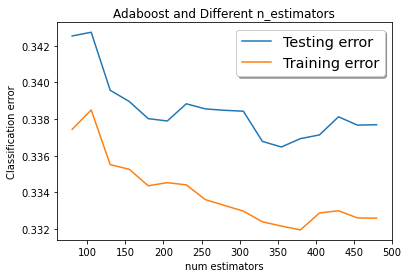

Test error minimized at n_estimators = 355


In [25]:
# Plot testing vs train error
plt.figure()
plt.plot(n_estimators, test_err, label='Testing error')
plt.plot(n_estimators, train_err, label='Training error')
plt.xlabel('num estimators')
plt.ylabel('Classification error')
plt.title('Adaboost and Different n_estimators')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

print('Test error minimized at n_estimators = %i' % n_estimators[np.argmin(test_err)])

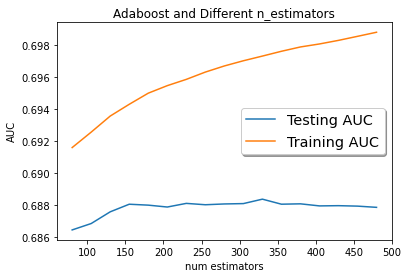

Test auc maximized at n_estimators = 330
max auc: 0.6883712955876602


In [26]:
# Plot AUC
plt.figure()
plt.plot(n_estimators, test_auc, label='Testing AUC')
plt.plot(n_estimators, train_auc, label='Training AUC')
plt.xlabel('num estimators')
plt.ylabel('AUC')
plt.title('Adaboost and Different n_estimators')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

print('Test auc maximized at n_estimators = %i' % n_estimators[np.argmax(test_auc)])
print('max auc:', np.max(test_auc))

## Single model output

In [ ]:
clf = AdaBoostClassifier(n_estimators=500)
clf.fit(X_train, Y_train)

In [ ]:
Y_val_pred_prob=clf.predict_proba(X_val)[:,1]
AUC_score(Y_val,Y_val_pred_prob)

In [ ]:
Y_val_pred=clf.predict(X_val)
confusion_matrix(Y_val,Y_val_pred)

In [ ]:
Y_train_pred=clf.predict(X_train)
confusion_matrix(Y_train,Y_train_pred)

In [ ]:
sum(Y_val_pred)

We have no trials predicted as positive despite reaching 0.69 on our validation set. We probably need to weight the samples to counter the class imbalance effects. 

## Try weighting the negative samples 5x due to there having more than 5x positive samples

In [29]:
(len(Y_val) - sum(Y_val)) / sum(Y_val) # 5x more positive samples 

5.465093411996067

In [30]:
clf = RandomForestClassifier(n_estimators=500, random_state=0, criterion = 'gini', min_samples_leaf=10, max_depth=60)
clf.fit(X_train, Y_train, sample_weight=copy.deepcopy(Y_train)*4 + 1)

RandomForestClassifier(max_depth=20, min_samples_leaf=30, n_estimators=500,
                       random_state=0)

In [31]:
Y_val_pred_prob=clf.predict_proba(X_val)[:,1]
AUC_score(Y_val,Y_val_pred_prob)

0.6895500345629634

In [32]:
Y_val_pred=clf.predict(X_val)
confusion_matrix(Y_val,Y_val_pred)

array([[26464,  6884],
       [ 3386,  2716]])

Confusion matrix shows that some samples are being classified to be negative! But there are a lot of errors still. 

## Output for submissions - evaluate on test set 

In [ ]:
Y_test_pred_prob=clf.predict_proba(X_test)[:,1]

In [ ]:
def to_submission(ids, y_test_predicted_probability):
    y_test=pd.DataFrame(y_test_predicted_probability,columns=['loan_status'], index=ids)
    y_test.index.name = 'id'
    y_test.to_csv('data/submission.csv')
    return

to_submission(pd.read_csv("data/2022-02-07_LOANS_TEST.csv")['id'].values, Y_test_pred_prob)